Connected to base (Python 3.10.9)

## Fraud Detection: Прогнозування банківського шахрайства
**Мета проєкту:** Побудова моделі машинного навчання для виявлення аномальних транзакцій. 

**Ключовий виклик:** Робота з критично незбалансованими даними (Imbalanced Classification), де частка шахрайських операцій становить лише малий відсоток від загальної кількості

Імпорт необхідних бібліотек для роботи

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# 1. Дослідницький аналіз даних (EDA)

На цьому етапі ми аналізуємо дистрибуцію ознак та кореляцію між ними. Особливу увагу приділяємо тому, як розподілені доходи, кредитні ліміти та скорингові бали, щоб виявити потенційні патерни шахрайської поведінки.

In [3]:
train = pd.read_csv('data/train.csv')

In [4]:
train.head(5)

,income,name_email_similarity,prev_address_months_count,current_address_months_count,intended_balcon_amount,payment_type,zip_count_4w,employment_status,credit_risk_score,email_is_free,phone_home_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,device_os,month,x2,target_fraud
0,0.1,0.440835,-1,115,-1.458281,AC,3269,CA,79,1,1,-1,0,200.0,0,linux,3,-0.595347,0
1,0.1,0.225276,190,5,-1.515477,AC,1243,CA,94,1,1,-1,0,200.0,0,windows,6,1.165555,0
2,0.9,0.782864,48,11,-0.497437,AD,224,CA,158,0,1,15,0,1500.0,0,macintosh,4,-0.324802,0
3,0.6,0.910046,95,153,-0.669298,AC,1122,CA,177,0,1,-1,1,500.0,0,windows,3,-1.088191,0
4,0.2,0.893974,-1,127,-1.588113,AB,702,CD,179,0,1,9,1,200.0,0,windows,5,-2.622994,0


In [5]:
train.describe()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,intended_balcon_amount,zip_count_4w,credit_risk_score,email_is_free,phone_home_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,month,x2,target_fraud
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,0.578937,0.487819,14.729580,99.164750,8.526481,1517.676136,139.266490,0.518204,0.493208,11.124234,0.248638,552.164140,0.024084,3.659572,0.011038,0.011050
std,0.288183,0.291409,43.145049,94.075894,20.511901,964.595056,71.479024,0.499669,0.499954,12.122546,0.432224,506.998965,0.153310,2.117141,1.012511,0.104537
min,0.100000,0.000009,-1.000000,-1.000000,-15.739893,1.000000,-164.000000,0.000000,0.000000,-1.000000,0.000000,190.000000,0.000000,0.000000,-4.783370,0.000000
25%,0.300000,0.214967,-1.000000,27.000000,-1.179533,886.000000,90.000000,0.000000,0.000000,1.000000,0.000000,200.000000,0.000000,2.000000,-0.670499,0.000000
50%,0.600000,0.486036,-1.000000,64.000000,-0.833729,1208.000000,130.000000,1.000000,0.000000,6.000000,0.000000,200.000000,0.000000,4.000000,0.004763,0.000000
75%,0.800000,0.754762,-1.000000,154.000000,-0.082155,1844.000000,188.000000,1.000000,1.000000,25.000000,0.000000,1000.000000,0.000000,5.000000,0.684745,0.000000
max,0.900000,1.000000,386.000000,423.000000,112.613538,6650.000000,387.000000,1.000000,1.000000,32.000000,1.000000,2100.000000,1.000000,7.000000,6.542492,1.000000


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   income                        500000 non-null  float64
 1   name_email_similarity         500000 non-null  float64
 2   prev_address_months_count     500000 non-null  int64  
 3   current_address_months_count  500000 non-null  int64  
 4   intended_balcon_amount        500000 non-null  float64
 5   payment_type                  500000 non-null  object 
 6   zip_count_4w                  500000 non-null  int64  
 7   employment_status             500000 non-null  object 
 8   credit_risk_score             500000 non-null  int64  
 9   email_is_free                 500000 non-null  int64  
 10  phone_home_valid              500000 non-null  int64  
 11  bank_months_count             500000 non-null  int64  
 12  has_other_cards               500000 non-nul

<ipython-input-8-db141d4ff97c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(), cmap='coolwarm')


<Axes: >

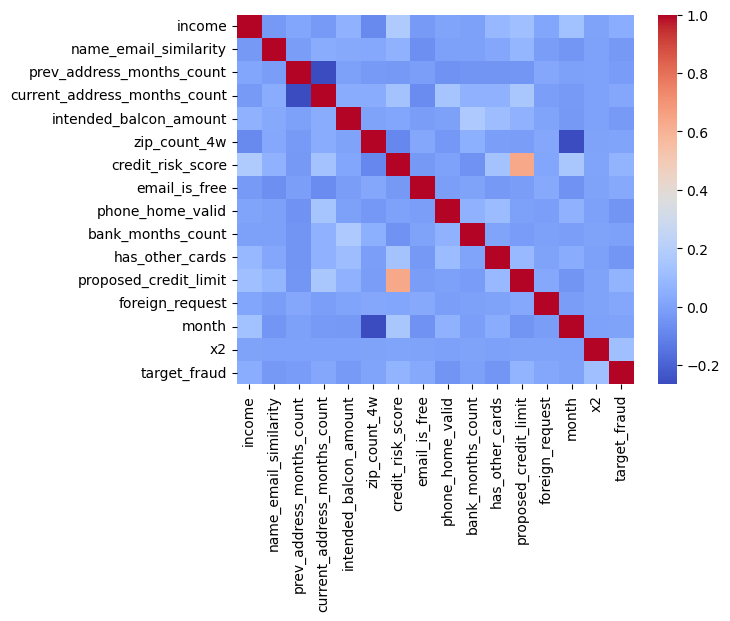

In [8]:
sns.heatmap(train.corr(), cmap='coolwarm')

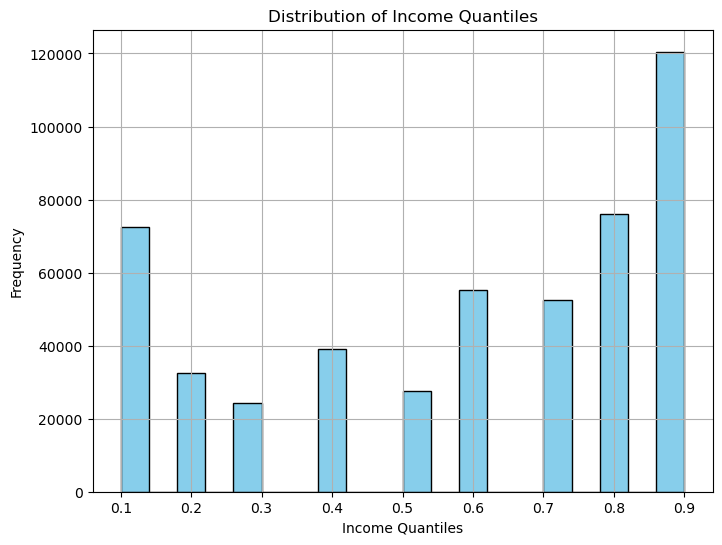

In [10]:
income_data = train['income']
# Plot histogram

plt.figure(figsize=(8, 6))
plt.hist(income_data, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Income Quantiles')
plt.xlabel('Income Quantiles')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 2. Очистка даних та обробка пропусків

Під час аналізу виявлено, що в датасеті присутні значення -1. Вони маркують відсутність даних (наприклад, термін проживання за адресою або кількість місяців у банку). 

**Стратегія:** Ми ідентифікуємо ці пропуски для подальшої коректної обробки (імпутації або виділення в окрему категорію), щоб модель не сприймала -1 як реальне числове значення.

In [12]:
train['prev_address_months_count'].unique()

array([ -1, 190,  48,  95,  11,  30,  33,  10, 129,  62, 175, 161,  55,
        34,  35, 197,  12,  32,  24,   9,  27,  60,  31,  29,  53, 300,
       324,  54,  58,  28,  26, 116,  59,   8,  52,  23,  44, 151, 152,
        25,  39, 142, 101, 210, 102, 317,  40,  51,  18,  61,  63, 107,
        13,  93,  45,  64,  38,  20,  56, 103, 330,  96,  71,  97, 100,
        19, 331,  92, 113, 146,  94,  14,  41,  57, 106, 110, 295, 339,
       204, 104,  43, 127, 288, 105, 224, 188,  21, 141, 147, 159, 177,
       214, 167, 114, 179, 296,  77,  87,  88,  36, 302, 308, 118,  99,
       231, 134, 137,  50, 305, 144, 180,  47, 226, 125, 108,  42,  66,
        91, 316,  22, 150, 255,  67,  49, 303,  80, 223, 121,  46, 157,
       117, 294,  84, 115, 166,  78, 174, 240,  86, 201, 264,  90,  79,
       153, 235, 145, 163, 311,  85, 323,  74, 228,  37,  89, 215, 233,
       164, 217, 200, 325, 112,  65, 120, 135, 298, 199,  69,   7, 198,
        98,  82, 321, 310, 239,  83, 170, 307, 130, 111, 140, 28

In [15]:
(train['prev_address_months_count'] == -1).sum()

380678

In [16]:
(train['current_address_months_count'] == -1).sum()

1768

In [22]:
train['employment_status'].unique()

array(['CA', 'CD', 'CC', 'CF', 'CB', 'CE', 'CG'], dtype=object)

In [23]:
(train['bank_months_count'] == -1).sum()

123642

In [24]:
train['bank_months_count'].unique()

array([-1, 15,  9, 16, 29,  1,  5,  7, 30, 28,  3, 31, 10, 25, 20, 21,  6,
        2, 14, 11,  4, 26, 12, 22, 27, 19, 18, 32, 24, 23,  8, 17, 13])

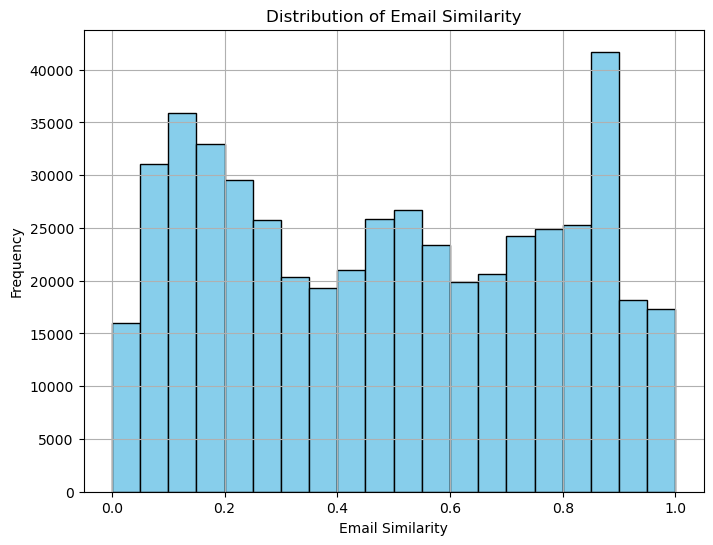

In [27]:
plt.figure(figsize=(8, 6))
plt.hist(train['name_email_similarity'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Email Similarity')
plt.xlabel('Email Similarity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

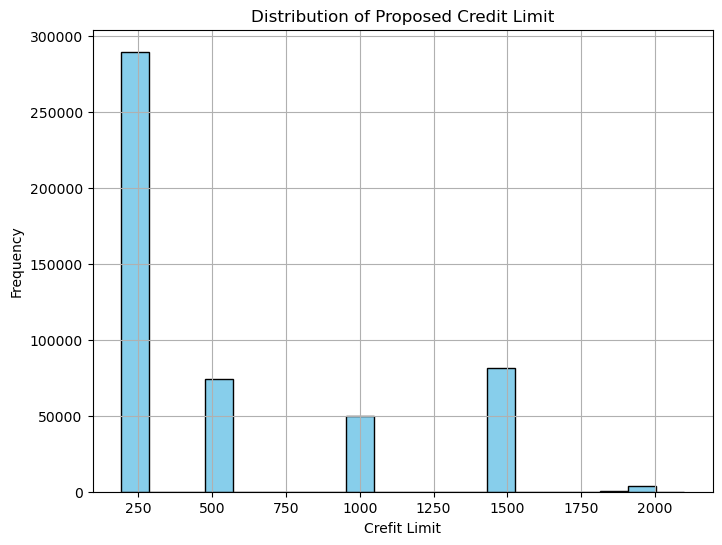

In [28]:
plt.figure(figsize=(8, 6))
plt.hist(train['proposed_credit_limit'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Proposed Credit Limit')
plt.xlabel('Crefit Limit')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

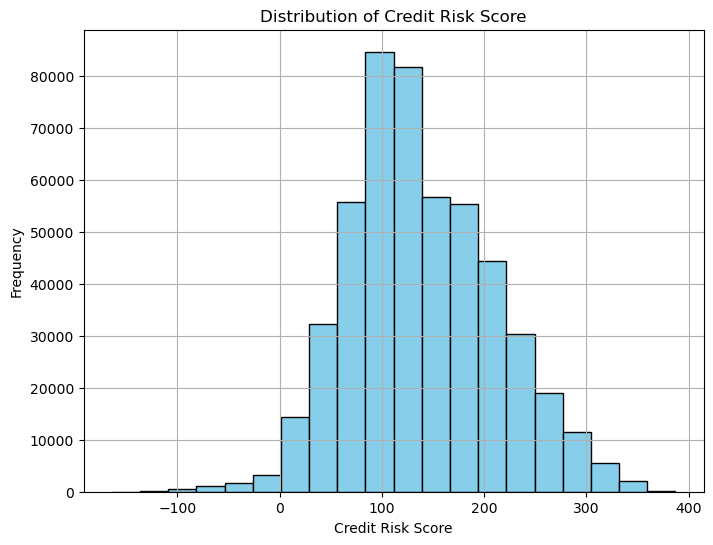

In [29]:
plt.figure(figsize=(8, 6))
plt.hist(train['credit_risk_score'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Credit Risk Score')
plt.xlabel('Credit Risk Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [30]:
train_1 = train.copy()

In [32]:
train.drop(columns=['prev_address_months_count', 'current_address_months_count' , 'bank_months_count'])

,income,name_email_similarity,intended_balcon_amount,payment_type,zip_count_4w,employment_status,credit_risk_score,email_is_free,phone_home_valid,has_other_cards,proposed_credit_limit,foreign_request,device_os,month,x2,target_fraud
0,0.1,0.440835,-1.458281,AC,3269,CA,79,1,1,0,200.0,0,linux,3,-0.595347,0
1,0.1,0.225276,-1.515477,AC,1243,CA,94,1,1,0,200.0,0,windows,6,1.165555,0
2,0.9,0.782864,-0.497437,AD,224,CA,158,0,1,0,1500.0,0,macintosh,4,-0.324802,0
3,0.6,0.910046,-0.669298,AC,1122,CA,177,0,1,1,500.0,0,windows,3,-1.088191,0
4,0.2,0.893974,-1.588113,AB,702,CD,179,0,1,1,200.0,0,windows,5,-2.622994,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0.9,0.878770,-0.707995,AB,3104,CB,136,1,1,1,200.0,0,linux,4,1.724062,0
499996,0.9,0.869952,-0.975458,AC,681,CB,330,0,0,0,1500.0,0,linux,7,-0.698393,0
499997,0.9,0.744863,-1.212520,AB,2216,CA,212,1,0,0,1500.0,0,macintosh,3,-0.060000,0
499998,0.4,0.014156,-0.847700,AB,2692,CA,179,1,0,1,200.0,0,linux,1,0.545959,0


In [33]:
train.drop(columns=['proposed_credit_limit'])

,income,name_email_similarity,prev_address_months_count,current_address_months_count,intended_balcon_amount,payment_type,zip_count_4w,employment_status,credit_risk_score,email_is_free,phone_home_valid,bank_months_count,has_other_cards,foreign_request,device_os,month,x2,target_fraud
0,0.1,0.440835,-1,115,-1.458281,AC,3269,CA,79,1,1,-1,0,0,linux,3,-0.595347,0
1,0.1,0.225276,190,5,-1.515477,AC,1243,CA,94,1,1,-1,0,0,windows,6,1.165555,0
2,0.9,0.782864,48,11,-0.497437,AD,224,CA,158,0,1,15,0,0,macintosh,4,-0.324802,0
3,0.6,0.910046,95,153,-0.669298,AC,1122,CA,177,0,1,-1,1,0,windows,3,-1.088191,0
4,0.2,0.893974,-1,127,-1.588113,AB,702,CD,179,0,1,9,1,0,windows,5,-2.622994,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0.9,0.878770,-1,62,-0.707995,AB,3104,CB,136,1,1,25,1,0,linux,4,1.724062,0
499996,0.9,0.869952,-1,307,-0.975458,AC,681,CB,330,0,0,-1,0,0,linux,7,-0.698393,0
499997,0.9,0.744863,-1,67,-1.212520,AB,2216,CA,212,1,0,1,0,0,macintosh,3,-0.060000,0
499998,0.4,0.014156,-1,103,-0.847700,AB,2692,CA,179,1,0,1,1,0,linux,1,0.545959,0


# 3. Feature Engineering та Preprocessing Pipeline

Для забезпечення чистоти експерименту та уникнення Data Leakage, я використовую Pipeline та ColumnTransformer.



*   Числові ознаки: Масштабування за допомогою StandardScaler.
*   Категоріальні ознаки: Кодування через OneHotEncoder. Це дозволяє автоматизувати підготовку даних як для тренувальної, так і для тестової вибірок.



In [48]:
numeric_features = ['prev_address_months_count', 'current_address_months_count', 'zip_count_4w', 
                    'credit_risk_score', 'bank_months_count', 'proposed_credit_limit', 'month']
# Columns to encode

categorical_features = ['payment_type', 'employment_status', 'device_os']
# Columns not to scale or encode

other_features = [col for col in train.columns if col not in numeric_features + categorical_features]
# Apply standard scaling to numeric features

scaler = StandardScaler()
scaled_data = scaler.fit_transform(train[numeric_features])
scaled_df = pd.DataFrame(scaled_data, columns=numeric_features)
# Apply one-hot encoding to categorical features

encoded_df = pd.get_dummies(train[categorical_features], prefix=categorical_features)
# Concatenate scaled numeric features, encoded categorical features, and other features into a single DataFrame

preprocessed_data = pd.concat([scaled_df, encoded_df, train[other_features]], axis=1)

In [49]:
preprocessed_data

,prev_address_months_count,current_address_months_count,zip_count_4w,credit_risk_score,bank_months_count,proposed_credit_limit,month,payment_type_AA,payment_type_AB,payment_type_AC,...,device_os_x11,income,name_email_similarity,intended_balcon_amount,email_is_free,phone_home_valid,has_other_cards,foreign_request,x2,target_fraud
0,-0.364575,0.168324,1.815607,-0.843136,-1.000140,-0.694606,-0.311539,0,0,1,...,0,0.1,0.440835,-1.458281,1,1,0,0,-0.595347,0
1,4.062357,-1.000946,-0.284758,-0.633284,-1.000140,-0.694606,1.105467,0,0,1,...,0,0.1,0.225276,-1.515477,1,1,0,0,1.165555,0
2,0.771130,-0.937167,-1.341161,0.262084,0.319716,1.869504,0.160796,0,0,0,...,0,0.9,0.782864,-0.497437,0,1,0,0,-0.324802,0
3,1.860480,0.572254,-0.410200,0.527897,-1.000140,-0.102888,-0.311539,0,0,1,...,0,0.6,0.910046,-0.669298,0,1,1,0,-1.088191,0
4,-0.364575,0.295881,-0.845616,0.555877,-0.175230,-0.694606,0.633132,0,1,0,...,0,0.2,0.893974,-1.588113,0,1,1,0,-2.622994,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,-0.364575,-0.395051,1.644551,-0.045699,1.144626,-0.694606,0.160796,0,1,0,...,0,0.9,0.878770,-0.707995,1,1,1,0,1.724062,0
499996,-0.364575,2.209232,-0.867387,2.668387,-1.000140,1.869504,1.577803,0,0,1,...,0,0.9,0.869952,-0.975458,0,0,0,0,-0.698393,0
499997,-0.364575,-0.341902,0.723956,1.017551,-0.835158,1.869504,-0.311539,0,1,0,...,0,0.9,0.744863,-1.212520,1,0,0,0,-0.060000,0
499998,-0.364575,0.040768,1.217428,0.555877,-0.835158,-0.694606,-1.256210,0,1,0,...,0,0.4,0.014156,-0.847700,1,0,1,0,0.545959,0


In [51]:
preprocessed_data.corr()['target_fraud'].sort_values(ascending=False)

target_fraud                    1.000000
x2                              0.118485
device_os_windows               0.070504
credit_risk_score               0.070151
proposed_credit_limit           0.069167
income                          0.043529
payment_type_AC                 0.036526
email_is_free                   0.028216
employment_status_CA            0.027723
current_address_months_count    0.019909
foreign_request                 0.018212
device_os_macintosh             0.011560
zip_count_4w                    0.010333
employment_status_CC            0.003843
month                           0.003613
device_os_x11                   0.001131
employment_status_CG            0.000273
payment_type_AD                -0.000599
payment_type_AE                -0.001685
payment_type_AB                -0.003787
bank_months_count              -0.006964
employment_status_CE           -0.010834
employment_status_CD           -0.011986
employment_status_CB           -0.019124
employment_statu

In [55]:
X = preprocessed_data.drop(columns='target_fraud')

In [57]:
y = preprocessed_data['target_fraud']

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Побудова Baseline моделі

Як базову модель використовуємо логістичну регресію. Для пошуку оптимальних параметрів регуляризації використовуємо GridSearchCV. Оскільки класи незбалансовані, основним фокусом є метрика ROC-AUC, яка краще відображає якість розділення класів, ніж Accuracy.

In [72]:
param_grid_lr = {
    'penalty': ['l1', 'l2'],  # Penalty type
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'solver': ['liblinear'],  # Algorithm to use in the optimization problem
    'class_weight': [None, 'balanced'],  # Weights associated with classes
    'max_iter': [100, 200, 300]  # Maximum number of iterations
}

In [80]:
param_grid_lr = {
    'penalty': ['l1', 'l2'],  # Penalty type
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    #'solver': ['liblinear'],  # Algorithm to use in the optimization problem
    'class_weight': ['balanced'],  # Weights associated with classes
}

In [81]:
grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='roc_auc')

In [83]:
grid_search_lr.fit(X_train, y_train)

/Users/senya/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/senya/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'class_weight': ['balanced'],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [84]:
best_params = grid_search_lr.best_params_
# Get the best model

best_model = grid_search_lr.best_estimator_

In [85]:
best_params

{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2'}

In [86]:
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

In [87]:
roc_auc = roc_auc_score(y_test, y_pred_proba)

In [88]:
roc_auc

0.8738575994253124

# 5. Перехід до ансамблевих методів

Для покращення результатів тестуємо складніші алгоритми — Random Forest та Gradient Boosting. Вони краще вловлюють нелінійні залежності та стійкіші до викидів у банківських даних

In [149]:
train_rf = pd.read_csv('data/train.csv')

In [153]:
numeric_features_rf = [ 'zip_count_4w', 'credit_risk_score', 'month']
# Columns to encode

categorical_features_rf = ['payment_type', 'employment_status', 'device_os']

In [154]:
other_features_rf = [col for col in train_rf.columns if col not in numeric_features_rf + categorical_features_rf]

In [156]:
numerical_df_rf = pd.DataFrame(train_rf[numeric_features_rf], columns=numeric_features_rf)

In [158]:
encoded_df_rf = pd.get_dummies(train_rf[categorical_features_rf], prefix=categorical_features_rf)
# Concatenate scaled numeric features, encoded categorical features, and other features into a single DataFrame

preprocessed_data_rf = pd.concat([numerical_df_rf, encoded_df_rf, train_rf[other_features_rf]], axis=1)

In [159]:
preprocessed_data_rf

,zip_count_4w,credit_risk_score,month,payment_type_AA,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CA,employment_status_CB,...,device_os_x11,income,name_email_similarity,intended_balcon_amount,email_is_free,phone_home_valid,has_other_cards,foreign_request,x2,target_fraud
0,3269,79,3,0,0,1,0,0,1,0,...,0,0.1,0.440835,-1.458281,1,1,0,0,-0.595347,0
1,1243,94,6,0,0,1,0,0,1,0,...,0,0.1,0.225276,-1.515477,1,1,0,0,1.165555,0
2,224,158,4,0,0,0,1,0,1,0,...,0,0.9,0.782864,-0.497437,0,1,0,0,-0.324802,0
3,1122,177,3,0,0,1,0,0,1,0,...,0,0.6,0.910046,-0.669298,0,1,1,0,-1.088191,0
4,702,179,5,0,1,0,0,0,0,0,...,0,0.2,0.893974,-1.588113,0,1,1,0,-2.622994,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,3104,136,4,0,1,0,0,0,0,1,...,0,0.9,0.878770,-0.707995,1,1,1,0,1.724062,0
499996,681,330,7,0,0,1,0,0,0,1,...,0,0.9,0.869952,-0.975458,0,0,0,0,-0.698393,0
499997,2216,212,3,0,1,0,0,0,1,0,...,0,0.9,0.744863,-1.212520,1,0,0,0,-0.060000,0
499998,2692,179,1,0,1,0,0,0,1,0,...,0,0.4,0.014156,-0.847700,1,0,1,0,0.545959,0


In [160]:
X_rf = preprocessed_data_rf.drop(columns='target_fraud')
y_rf = preprocessed_data_rf['target_fraud']
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

In [164]:
rf_model = RandomForestClassifier()

In [165]:
param_dist_rf = {
    'n_estimators': randint(50, 200),  # Number of trees in the forest
    'max_depth': [None] + list(randint(5, 50).rvs(5)),  # Maximum depth of the trees
    'min_samples_split': randint(2, 20),  # Minimum number of samples required to split a node
    'min_samples_leaf': randint(1, 10)  # Minimum number of samples required at each leaf node
}

In [166]:
random_search_rf = RandomizedSearchCV(rf_model, param_distributions=param_dist_rf, n_iter=100, cv=5, scoring='roc_auc', random_state=42)

In [167]:
random_search_rf.fit(X_train_rf, y_train_rf)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'max_depth': [None, 40, 15, 6, 21, 27],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x2918beb30>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x13c0500a0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x13c3bbcd0>},
                   random_state=42, scoring='roc_auc')

In [169]:
best_params_rf_random = random_search_rf.best_params_

In [170]:
best_model_rf_random = random_search_rf.best_estimator_

In [171]:
best_params_rf_random

{'max_depth': 15,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 196}

In [172]:
y_pred_proba_rf = best_model_rf_random.predict_proba(X_test_rf)[:, 1]

In [173]:
roc_auc_rf = roc_auc_score(y_test_rf, y_pred_proba_rf)

In [174]:
roc_auc_rf

0.8725821350716334

In [199]:
from sklearn.ensemble import GradientBoostingClassifier

In [200]:
from sklearn.metrics import accuracy_score

In [201]:
hyperparameters = [
    {'learning_rate': 0.05, 'n_estimators': 200, 'max_depth': 4},
    {'learning_rate': 0.1, 'n_estimators': 300, 'max_depth': 5}, 
    {'learning_rate': 0.5, 'n_estimators': 400, 'max_depth': 10}, 
]
# Function to train Gradient Boosting Classifier on a subset with given hyperparameters

def train_on_subset_with_params(X_subset, y_subset, params):
    gb_classifier = GradientBoostingClassifier(**params)
    gb_classifier.fit(X_subset, y_subset)
    return gb_classifier, accuracy_score(y_subset, gb_classifier.predict(X_subset))
# Split the training data into subsets

subset_size = 10000
num_subsets = int(np.ceil(len(X_train) / subset_size))
subset_models = []
subset_accuracies = []
for params in hyperparameters:
    subset_model_accuracies = []
    for i in range(num_subsets):
        start_idx = i * subset_size
        end_idx = min((i + 1) * subset_size, len(X_train))
        X_subset = X_train[start_idx:end_idx]
        y_subset = y_train[start_idx:end_idx]
        model, accuracy = train_on_subset_with_params(X_subset, y_subset, params)
        subset_models.append(model)
        subset_model_accuracies.append(accuracy)
    mean_accuracy = np.mean(subset_model_accuracies)
    subset_accuracies.append(mean_accuracy)

In [202]:
best_params_idx = np.argmax(subset_accuracies)
best_params = hyperparameters[best_params_idx]

In [203]:
best_params

{'learning_rate': 0.1, 'n_estimators': 300, 'max_depth': 5}

In [204]:
best_model_full, _ = train_on_subset_with_params(X_train, y_train, best_params)

In [205]:
y_pred_proba_1 = best_model_full.predict_proba(X_test)[:, 1]

In [206]:
roc_auc_1 = roc_auc_score(y_test, y_pred_proba)

In [208]:
roc_auc_1 = roc_auc_score(y_test, y_pred_proba_1)

In [209]:
roc_auc_1

0.8810659492126007

# 6. Фінальна оцінка та висновки
Підсумкова модель Gradient Boosting Classifier демонструє високий показник ROC-AUC(0,88). Це свідчить про те, що алгоритм ефективно ранжує транзакції за ступенем ризику. Наступним кроком для покращення могло б бути використання техніки SMOTE для синтетичного балансування класів або поглиблений Feature Engineering.